<h1 style = "text-align: center;"><strong>WEATHER PREDICTIONS NOTEBOOK</strong></h1>

---
<h2 style = "text-align: center;"><em>State the Problem</em></h2>

<h3 style = "text-align: center;">"5W1H" Method</h3>

<p style = "text-align: center;">I want to train a model able to predict apparent temperatures, for a given day, at a given address in France, to assess the weather conditions</p>

---
<h2 style = "text-align: center;"><em>Prepare the Tools</em></h2>

<h3 style = "text-align: center;">Resources</h3>

<ul>
    <li>Domain Documentation
        <ul>
            <li><a href = "https://en.wikipedia.org/wiki/Toulouse">Toulouse</a></li>
            <li><a href = "https://en.wikipedia.org/wiki/Weather_forecasting">Weather Forecasting</a></li>
            <li><a href = "https://en.wikipedia.org/wiki/Meteorology">Meteorology</a></li>
            <li><a href = "https://en.wikipedia.org/wiki/Humid_subtropical_climate">Humid Subtropical Climate</a></li>
        </ul>
    </li>
    <br>
    <li>Technical Documentation
        <ul>
            <li><a href = "https://numpy.org/doc/stable/index.html">NumPy</a></li>
            <li><a href = "https://pandas.pydata.org/docs/">Pandas</a></li>
            <li><a href = "https://matplotlib.org/stable/">Matplotlib</a></li>
            <li><a href = "https://seaborn.pydata.org/">Seaborn</a></li>
            <li><a href = "https://scikit-learn.org/stable/index.html">Scikit-learn</a></li>
        </ul>
    </li>
    <br>
    <li>API Documentation
        <ul>
            <li><a href = "https://adresse.data.gouv.fr/api-doc/adresse">API Adresse</a></li>
            <li><a href = "https://open-meteo.com">Open Meteo</a></li>
        </ul>
    </li>
</ul>

<h3 style = "text-align: center;">Libraries</h3>

In [9]:
# Import libraries
import requests
from requests.utils import quote
import os
import pandas as pd
import numpy as np
import folium
import datetime as dt
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

<h3 style = "text-align: center;">Functions</h3>

In [11]:
# Define a function to get the latitude and longitude of an address
def get_latitude_and_longitude(address):
    """
    Purpose: 
        Get the latitude and longitude of a given address
    Parameters:
        address (str): Address in the format "1 Rue Ernest Roschach, 31000 Toulouse"
    Returns:
        tuple: A tuple containing the latitude and longitude of the specified address
    """
    location_api_root_url = "https://api-adresse.data.gouv.fr/search/?q="
    formatted_address = quote(address)
    location_api_endpoint = location_api_root_url + formatted_address
    location_latitude = None
    location_longitude = None
    
    try:
        location_api_response = requests.get(location_api_endpoint)
        if location_api_response.status_code == 200:        
            location_address_dict = location_api_response.json()               
            if "features" in location_address_dict and len(location_address_dict["features"]) > 0:
                location_coordinates = location_address_dict["features"][0]["geometry"]["coordinates"][::-1]
                location_latitude = location_coordinates[0]
                location_longitude = location_coordinates[1]
            return location_latitude, location_longitude
        else:
            print(f"Error message: Status code {location_api_response.status_code}")
            return None, None
            
    except Exception as e:
        print(f"Error: {e}")
        raise


# Display a location on a map
def display_location(location_address, location_latitude, location_longitude):
    """
    Purpose: 
        Display a location on a map
    Parameters:
        location_address (str): Address of the location
        location_latitude (float): Latitude of the location
        location_longitude (float): Longitude of the location
    Returns:
        object: An object representing the location on a map
    """
    try:
        location_on_map = folium.Map(
            location = [location_latitude, location_longitude],
            zoom_start = 15
        )
        popup_html = f"""
        <div style = "text-align: center;">
            <p>
                <strong>Address</strong>
                <br>{location_address}
            </p>
            <p>
                <strong>Latitude</strong>
                <br>{location_latitude}
            </p>
            <p>
                <strong>Longitude</strong>
                <br>{location_longitude}
            </p>
        </div>
        """
        folium.Marker(
            location = [location_latitude, location_longitude],
            popup = folium.Popup(popup_html, max_width = 300),
            icon = folium.Icon(color = "blue", icon = "info-sign", prefix = "glyphicon")
        ).add_to(location_on_map)
        return location_on_map

    except Exception as e:
        print(f"Error: {e}")
        raise

# Define a function to check a dataframe
def check_dataframe(dataframe: pd.DataFrame):
    """
    Purpose:
        Check a DataFrame for general information
    Parameters:
        dataframe (pd.DataFrame): DataFrame to check
    Returns:
        None: This function prints general information to the console
    """
    try:
        print("GENERAL INFORMATION")
        print(dataframe.info())
        print()
        print("FIRST ROWS")
        print(dataframe.head())
        print()
        print("LAST ROWS")
        print(dataframe.tail())
        print()
        print("DUPLICATED ROWS")
        print(f"Count of duplicated rows: {dataframe.duplicated().sum()}")
        print()
        print("MISSING VALUES BY COLUMN")
        print(dataframe.isna().sum().reset_index(name = "missing_values_count").rename(columns = {"index": "column_name"}))
        print()
        print("UNIQUE VALUES BY COLUMN")
        print(dataframe.nunique().reset_index(name = "unique_values_count").rename(columns = {"index": "column_name"}))
        print()
        print("STATISTICS")
        print(dataframe.describe(include = "all"))
        
    except Exception as e:
        print(f"Error: {e}")
        raise


# Define a function to calculate statistics
def calculate_statistics(dataframe: pd.DataFrame, column_name: str, return_distribution_dict: bool = True):
    """
    Purpose: 
        Check a column of a DataFrame for the distribution of values
    Parameters:
        dataframe (pd.DataFrame): DataFrame containing the column to check
        column_name (str): Column to check
        return_distribution_dict (bool): Flag to return the distribution as a dictionary
    Returns:
        distribution_dict(dict): Dictionary containing statistics (range, Q1, Q2, spread, IQR, median, mean, mode(s),
        lower bound, upper bound, outliers, and skewness); if return_distribution_dict is True
        or
        None: if return_distribution_dict is False
    """
    try:
        column_data = dataframe[column_name]
        minimum_value = round(column_data.min(), 2)
        maximum_value = round(column_data.max(), 2)
        values_range = round(column_data.max() - column_data.min(), 2)
        Q1 = round(column_data.quantile(0.25), 2)
        median = round(column_data.median(), 2)
        Q3 = round(column_data.quantile(0.75),2)
        IQR = round(Q3 - Q1, 2)
        
        mean = round(column_data.mean(), 2)
        standard_deviation = round(column_data.std(), 2)
        
        unrounded_modes_list = column_data.mode().to_list()
        modes_list = [round(mode, 2) for mode in unrounded_modes_list]
        skewness = round(column_data.skew(), 2)
        
        lower_bound = round(Q1 - 1.5 * IQR, 2)
        upper_bound = round(Q3 + 1.5 * IQR, 2)
        outliers_df = dataframe[(column_data < lower_bound) | (column_data > upper_bound)]
        outliers_count = len(outliers_df)
        outliers_list = outliers_df[column_name].tolist() if outliers_count > 0 else []
        
        unique_values_count = column_data.nunique()
        
        distribution_dict = {
            "minimum_value": minimum_value,
            "maximum_value": maximum_value,
            "values_range": values_range,
            "Q1": Q1,
            "median": median,
            "Q3": Q3,
            "IQR": IQR,
            "mean": mean,
            "standard_deviation": standard_deviation,
            "modes_list": modes_list,
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
            "outliers_list": outliers_list,
            "outliers_count": outliers_count,
            "skewness": skewness,
            "unique_values_count": unique_values_count
        }

        if return_distribution_dict:
            return distribution_dict

        else:
            print("DISTRIBUTION")
            print(f"Range: {values_range}")
            print(f"Minimum value: {minimum_value}")
            print(f"Q1: {Q1}")
            print(f"Median: {median}")
            print(f"Q3: {Q3}")
            print(f"Maximum value: {maximum_value}")
            print(f"Spread (IQR): {IQR}")
            print(f"Mean: {mean}")
            print(f"Standard deviation: {standard_deviation}")
            print(f"Mode(s): {modes_list}")
            print(f"Skewness: {skewness}")
            print(f"Lower bound: {lower_bound}")
            print(f"Upper bound: {upper_bound}")
            print(f"Outliers: {outliers_list}")
            print(f"Outliers count: {outliers_count}")
            print(f"Unique values count: {unique_values_count}")
            
    except Exception as e:
        print(f"Error: {e}")
        raise


# Define a function to visualize a boxplot
def visualize_boxplot(dataframe: pd.DataFrame, column_name: str, label: str, title: str):
    """
    Purpose: 
        Plot a boxplot
    Parameters:
        dataframe (pd.DataFrame): DataFrame containing the column to check
        column_name (str): Column to check
        label (str): Label of the boxplot
        title (str): Title of the boxplot
    Result:
        None: This function displays a boxplot of the distribution
    """
    try:
        plt.figure(figsize = (12.5, 5))
        ax = plt.gca()
        ax.set_axisbelow(True)
        plt.boxplot(
            dataframe[column_name],
            labels = [label]
        )
        plt.grid(True, linestyle = "--")
        plt.ylabel(label, fontstyle = "italic")
        plt.ylim(-10, 40)
        plt.xlabel("")
        plt.xticks([])
        plt.title(title, fontweight = "bold")
        plt.tight_layout()
        plt.show()
    
    except Exception as e:
        print(f"Error: {e}")
        raise


# Define a function to visualize a histogram
def visualize_histogram(dataframe: pd.DataFrame, column_name: str, bins: int, label: str, x_label: str, title: str):
    """
    Purpose: 
        Plot a histogram of distribution frequencies
    Parameters:
        dataframe (pd.DataFrame): DataFrame containing the column to check
        column_name (str): Column to check
        bins (int): Number of bins of the histogram
        label (str): Label of the histogram
        x_label (str): Label of the x-axis
        title (str): Title of the histogram
    Result:
        None: This function displays a histogram of distribution frequencies
    """
    try:        
        plt.figure(figsize = (12.5, 5))
        ax = plt.gca()
        ax.set_axisbelow(True)
               
        hist, bin_edges  = np.histogram(dataframe[column_name], bins, range = (dataframe[column_name].min(), dataframe[column_name].max()))
        bin_width = bin_edges [1] - bin_edges [0]
        percentages = (hist / hist.sum()) * 100

        plt.bar(
            bin_edges[:-1], 
            percentages, 
            width = bin_width, 
            color = "blue", 
            edgecolor = "black", 
            label = label, 
            zorder = 2
        )
        plt.xlabel(x_label, fontstyle  = "italic")
        plt.ylabel("Distribution Frequencies (%)", fontstyle = "italic")
        plt.title(title, fontweight = "bold")
        plt.legend()
        plt.grid(True, linestyle = "--")
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error: {e}")
        raise


# Define a function to visualize a lineplot
def visualize_lineplot(dataframe: pd.DataFrame, column_name_x: str, column_name_y: str, x_label: str, y_label: str, title: str):
    """
    Purpose: 
        Plot a lineplot of distribution
    Parameters:
        dataframe (pd.DataFrame): DataFrame containing the columns to check
        column_name_x (str): Column for the x-axis
        column_name_y (str): Column for the y-axis
        y_label (str): Label for the y-axis
        x_label (str): Label for the x-axis
        title (str): Title of the line plot
    Result:
        None: This function displays a lineplot
    """
    try:
        plt.figure(figsize = (12.5, 5))
        ax = plt.gca()
        ax.set_axisbelow(True)
        plt.plot(dataframe[column_name_x], dataframe[column_name_y], color = "grey")
        plt.grid(True, linestyle = "--")
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%B\n%Y"))
        plt.ylim(-15, 45)
        plt.ylabel(y_label, fontstyle = "italic")
        plt.xlabel(x_label, fontstyle = "italic")
        plt.title(title, fontweight = "bold")
        plt.tight_layout()
        plt.show()
    
    except Exception as e:
        print(f"Error: {e}")
        raise


# Define a function to check correlations
def check_correlations(dataframe: pd.DataFrame):
    """
    Purpose:
        Check a DataFrame for correlations
    Parameters:
        dataframe (pd.DataFrame): DataFrame to check
    Returns:
        None: This function prints significant correlations to the console
    """
    try:
        print("CORRELATIONS OF NUMERIC COLUMNS")
        numeric_dataframe = dataframe.select_dtypes(include = "number")
        correlation_matrix = numeric_dataframe.corr()
        correlations_dict = {}
        
        for column in correlation_matrix.columns:
            correlation_details = []
            for index in correlation_matrix.index:
                if column != index:
                    correlation_value = correlation_matrix.at[index, column]
                    if 0.75 <= correlation_value < 1:
                        correlation_details.append((index, correlation_value, "Very strong positive correlation"))
                    elif 0.50 <= correlation_value < 0.75:
                        correlation_details.append((index, correlation_value, "Strong positive correlation"))
                    elif -0.75 <= correlation_value < -0.50:
                        correlation_details.append((index, correlation_value, "Strong negative correlation"))
                    elif -1 < correlation_value < -0.75:
                        correlation_details.append((index, correlation_value, "Very strong negative correlation"))
            
            if correlation_details:
                correlations_dict[column] = correlation_details
                
        if not correlations_dict: 
            print("No significant correlations")
        else:        
            for column in sorted(correlations_dict.keys()):
                correlated_columns = correlations_dict[column]
                correlated_columns_sorted = sorted(correlated_columns, key = lambda correlation_details: correlation_details[1], reverse = True)
                print(f'Column "{column}"')
                for correlated_column_name, correlation_value, correlation_type in correlated_columns_sorted:
                    print(f'{correlation_type} ({correlation_value:.2f}) with "{correlated_column_name}"')
                print()
                
    except Exception as e:
        print(f"Error: {e}")
        raise

---
<h2 style = "text-align: center;"><em>Collect Data</em></h2>

<h3 style = "text-align: center;">Source(s)</h3>

<h4 style = "text-align: center;">Location</h4>

In [15]:
# Store the address and its coordinates in a variable
location_address = "1 Rue Ernest Roschach, 31000 Toulouse"
location_latitude_and_longitude = get_latitude_and_longitude(location_address)

<h4 style = "text-align: center;">Daily Weather Characteristics</h4>

In [17]:
# Prepare and Store the API endpoint for daily weather data in a variable
date_today = dt.datetime.now()
date_5_years_ago = date_today - relativedelta(years = 5)
formatted_date_today = date_today.strftime("%Y-%m-%d")
formatted_date_5_years_ago = date_5_years_ago.strftime("%Y-%m-%d")
daily_weather_api_endpoint = (
    "https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={location_latitude_and_longitude[0]}&longitude={location_latitude_and_longitude[1]}&"
    f"start_date={formatted_date_5_years_ago}&"
    f"end_date={formatted_date_today}&"
    "daily=weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,"
    "apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,"
    "sunrise,sunset,daylight_duration,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,"
    "wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration&"
    "timezone=Europe%2FLondon&"
)

<h4 style = "text-align: center;">Hourly Weather Characteristics</h4>

In [19]:
# Prepare and Store the API endpoint for hourly weather data in a variable
date_today = dt.datetime.now()
date_5_years_ago = date_today - relativedelta(years = 5)
formatted_date_today = date_today.strftime("%Y-%m-%d")
formatted_date_5_years_ago = date_5_years_ago.strftime("%Y-%m-%d")
hourly_weather_api_endpoint = (
    "https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={location_latitude_and_longitude[0]}&longitude={location_latitude_and_longitude[1]}&"
    f"start_date={formatted_date_5_years_ago}&"
    f"end_date={formatted_date_today}&"
    "hourly=relative_humidity_2m,dew_point_2m,pressure_msl,cloud_cover,"
    "direct_radiation,direct_normal_irradiance,diffuse_radiation,global_tilted_irradiance,"
    "wind_speed_100m,wind_direction_100m,vapour_pressure_deficit,"
    "soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,"
    "soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,"
    "soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm&"
    "timezone=Europe%2FLondon&"
)

<h3 style = "text-align: center;">Check(s)</h3>

<h4 style = "text-align: center;">Location</h4>

In [22]:
# Display the address location on a map
address_location_on_map = display_location(
    location_address, 
    location_latitude_and_longitude[0], 
    location_latitude_and_longitude[1])
address_location_on_map

<h4 style = "text-align: center;">Daily Weather Characteristics</h4>

In [24]:
# Request the API to return daily weather data
try:
    daily_weather_api_response = requests.get(daily_weather_api_endpoint)
    if daily_weather_api_response.status_code == 200:
        daily_weather_dict = daily_weather_api_response.json()
        daily_weather_dict = daily_weather_dict["daily"]
        daily_weather_df = pd.DataFrame(daily_weather_dict)
        check_dataframe(daily_weather_df)
    else:
        print(f"Error: Status code {daily_weather_api_response.status_code}")

except Exception as e:
        print(f"Error: {e}")
        raise

GENERAL INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1828 entries, 0 to 1827
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   time                         1828 non-null   object 
 1   weather_code                 1827 non-null   float64
 2   temperature_2m_max           1827 non-null   float64
 3   temperature_2m_min           1827 non-null   float64
 4   temperature_2m_mean          1826 non-null   float64
 5   apparent_temperature_max     1827 non-null   float64
 6   apparent_temperature_min     1827 non-null   float64
 7   apparent_temperature_mean    1826 non-null   float64
 8   sunrise                      1828 non-null   object 
 9   sunset                       1828 non-null   object 
 10  daylight_duration            1828 non-null   float64
 11  sunshine_duration            1826 non-null   float64
 12  precipitation_sum            1826 non-null   float64
 13

<h4 style = "text-align: center;">Hourly Weather Characteristics</h4>

In [26]:
# Request the API to return hourly weather data
try:
    hourly_weather_api_response = requests.get(hourly_weather_api_endpoint)
    if hourly_weather_api_response.status_code == 200:
        hourly_weather_dict = hourly_weather_api_response.json()
        hourly_weather_dict = hourly_weather_dict["hourly"]
        hourly_weather_df = pd.DataFrame(hourly_weather_dict)
        check_dataframe(hourly_weather_df)
    else:
        print(f"Error: Status code {weather_api_response.status_code}")

except Exception as e:
        print(f"Error: {e}")
        raise

GENERAL INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43872 entries, 0 to 43871
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   time                           43872 non-null  object 
 1   relative_humidity_2m           43826 non-null  float64
 2   dew_point_2m                   43826 non-null  float64
 3   pressure_msl                   43826 non-null  float64
 4   cloud_cover                    43826 non-null  float64
 5   direct_radiation               43826 non-null  float64
 6   direct_normal_irradiance       43826 non-null  float64
 7   diffuse_radiation              43826 non-null  float64
 8   global_tilted_irradiance       43826 non-null  float64
 9   wind_speed_100m                43826 non-null  float64
 10  wind_direction_100m            43826 non-null  float64
 11  vapour_pressure_deficit        43826 non-null  float64
 12  soil_temperature_0_to_7cm 

<h3 style = "text-align: center;">Comment(s)</h3>

<h4 style = "text-align: center;">Location</h4>

<p>The address points to the city center of Toulouse; the largest city of the Occitanie region, in the South-West of France</p>
<p>The climate is considered as humid subtropical (temperate climate characterized by hot and humid summers, and cool to mild winters)</p>
<p style = "text-align: right;"><i>*cf. "Domain Documentation" in the "Resource(s)" section, at the top of the notebook</i></p>

<h4 style = "text-align: center;">Daily Weather Characteristics</h4>

<ul>
    <li>Column "time"
        <ul>Date of the record (iso8601, e.g. "2019-10-10")</ul>
    </li>
    <br>
    <li>Column "weather_code"
        <ul>Type of weather (WMO code, e.g. "3.0")</ul>
    </li>
    <br>
    <li>Column "temperature_2m_max"
        <ul>Maximum temperature at 2 meters above ground (C°, e.g. "20.3")</ul>
    </li>
    <br>
    <li>Column "temperature_2m_min"
        <ul>Minimum temperature at 2 meters above ground (C°, e.g. "9.9")</ul>
    </li>
    <br>
    <li>Column "temperature_2m_mean"
        <ul>Mean temperature at 2 meters above ground (C°, e.g. "15.0")</ul>
    </li>
    <br>
    <li>Column "apparent_temperature_max"
        <ul>Maximum apparent temperature (C°, e.g. "19.0")</ul>
    </li>
    <br>
    <li>Column "apparent_temperature_min"
        <ul>Minimum apparent temperature (C°, e.g. "8.9")</ul>
    </li>
    <br>
    <li>Column "apparent_temperature_mean"
        <ul>Mean apparent temperature (C°, e.g. "13.8")</ul>
    </li>
    <br>
    <li>Column "sunrise"
        <ul>Time of the sunrise (iso8601, e.g. "2019-10-10T07:01")</ul>
    </li>
    <br>
    <li>Column "sunset"
        <ul>Time of the sunset (iso8601, e.g. "2019-10-10T18:20")</ul>
    </li>
    <br>
    <li>Column "daylight_duration"
        <ul>Duration of daylight (seconds, e.g. "35875.14")</ul>
    </li>
    <br>
    <li>Column "sunshine_duration"
        <ul>Duration of sunshine (seconds, e.g. "32275.14")</ul>
    </li>
    <br>
    <li>Column "precipitation_sum"
        <ul>Sum of precipitation (mm, e.g. "0.0")</ul>
    </li>
    <br>
    <li>Column "rain_sum"
        <ul>Sum of rain (mm, e.g. "0.0")</ul>
    </li>
    <br>
    <li>Column "snowfall_sum"
        <ul>Sum of snowfall (cm, e.g. "0.0")</ul>
    </li>
    <br>
    <li>Column "precipitation_hours"
        <ul>Duration of precipitation (hours, e.g. "0.0")</ul>
    </li>
    <br>
    <li>Column "wind_speed_10m_max"
        <ul>Maximum wind speed at 10 meters above ground, on average over a few minutes (km/h; "12.3")</ul>
    </li>
    <br>
    <li>Column "wind_gusts_10m_max"
        <ul>Maximum wind speed at 10 meters above ground, on average over a few seconds (km/h; "28.4")</ul>
    </li>
    <br>
    <li>Column "wind_direction_10m_dominant"
        <ul>Dominant wind direction at 10 meters above ground (°, e.g. "272.0")</ul>
    </li>
    <br>
    <li>Column "shortwave_radiation_sum"
        <ul>Sum of solar radiation (MJ/m², e.g. "11.07")</ul>
    </li>
    <br>
    <li>Column "et0_fao_evapotranspiration"
        <ul>Sum of ET₀ Reference Evapotranspiration of a well watered grass field (mm, e.g. "2.08")</ul>
    </li>
    <br>
</ul>

<h4 style = "text-align: center;">Hourly Weather Characteristics</h4>

<ul>
    <li>Column "time"
        <ul>Date of the record (iso8601, e.g. "2019-10-11T00:00")</ul>
    </li>
    <br>
    <li>Column "relative_humidity_2m"
        <ul>Relative humidity at 2 meters above ground (%, e.g. "84.0")</ul>
    </li>
    <br>
    <li>Column "dew_point_2m"
        <ul>Dew point temperature at 2 meters above ground (°C, e.g. "9.2")</ul>
    </li>
    <br>
    <li>Column "pressure_msl"
        <ul>Atmospheric air pressure reduced to mean sea level (hPa, e.g. "1022.0")</ul>
    </li>
    <br>
    <li>Column "cloud_cover"
        <ul>Total cloud cover as an area fraction (%, e.g. "0.0")</ul>
    </li>
    <br>
    <li>Column "direct_radiation"
        <ul>Direct solar radiation as average of the preceding hour on the horizontal plane (W/m², e.g. "0.0")</ul>
    </li>
    <br>
    <li>Column "direct_normal_irradiance"
        <ul>Direct solar radiation as average of the preceding hour on the normal plane (W/m², e.g. "0.0")</ul>
    </li>
    <br>
    <li>Column "diffuse_radiation"
        <ul>Diffuse solar radiation as average of the preceding hour (W/m², e.g. "0.0")</ul>
    </li>
    <br>
    <li>Column "global_tilted_irradiance"
        <ul>Total radiation received on a tilted pane as average of the preceding hour. The calculation is assuming a fixed albedo of 20% and in isotropic sky (W/m², e.g. "0.0")</ul>
    </li>
    <br>
    <li>Column "wind_speed_100m"
        <ul>Wind speed at 100 meters above ground (km/h, e.g. "17.7")</ul>
    </li>
    <br>
    <li>Column "wind_direction_100m"
        <ul>Wind direction at 100 meters above ground (°, e.g. "114.0")</ul>
    </li>
    <br>
    <li>Column "vapour_pressure_deficit"
        <ul>Vapor Pressure Deificit (kPa, e.g. "0.23")</ul>
    </li>
    <br>
    <li>Column "soil_temperature_0_to_7cm"
        <ul>Average soil temperature from 0 to 7cm below ground (°C, e.g. "14.6")</ul>
    </li>
    <br>
    <li>Column "soil_temperature_7_to_28cm"
        <ul>Average soil temperature from 7 to 28cm below ground (°C, e.g. "17.7")</ul>
    </li>
    <br>
    <li>Column "soil_temperature_28_to_100cm"
        <ul>Average soil temperature from 28 to 100cm below ground (°C, e.g. "19.3")</ul>
    </li>
    <br>
    <li>Column "soil_temperature_100_to_255cm"
        <ul>Average soil temperature from 100 to 255cm below ground (°C, e.g. "20.2")</ul>
    </li>
    <br>
    <li>Column "soil_moisture_0_to_7cm"
        <ul>Average soil water content as volumetric mixing ratio from 0 to 7cm below ground (m³/m³, e.g. "0.204")</ul>
    </li>
    <br>
    <li>Column "soil_moisture_7_to_28cm"
        <ul> Average soil water content as volumetric mixing ratio from 7 to 28cm below ground (m3/m3, e.g. "0.163")</ul>
    </li>
    <br>
    <li>Column "soil_moisture_28_to_100cm"
        <ul>Average soil water content as volumetric mixing ratio from 28 to 100cm below ground (m3/m3, e.g. "0.117")</ul>
    </li>
    <br>
    <li>Column "soil_moisture_100_to_255cm"
        <ul>Average soil water content as volumetric mixing ratio from 100 to 255cm below ground (m3/m3, e.g. "0.248")</ul>
    </li>
</ul>

---
<h2 style = "text-align: center;"><em>Clean and Prepare Data</em></h2>

<h3 style = "text-align: center;">Cleaning and Preparation</h3>

<h4 style = "text-align: center;">Backups</h4>

In [37]:
# Save the dataframes
daily_weather_cleaned_df = daily_weather_df.copy()
hourly_weather_cleaned_df = hourly_weather_df.copy()

<h4 style = "text-align: center;">Daily Weather Characteristics</h4>

In [39]:
# Handle missing values
date_today = dt.datetime.now()
date_yesterday = date_today - relativedelta(days = 1)
formatted_date_today = date_today.strftime("%Y-%m-%d")
formatted_date_yesterday = date_yesterday.strftime("%Y-%m-%d")
daily_weather_cleaned_df["time"] = pd.to_datetime(daily_weather_cleaned_df["time"], format = "%Y-%m-%d")
daily_weather_cleaned_df["date"] = daily_weather_cleaned_df["time"].dt.strftime("%Y-%m-%d")
daily_weather_cleaned_df = daily_weather_cleaned_df[~daily_weather_cleaned_df["date"].isin(
    [formatted_date_today, formatted_date_yesterday]
)]

# Standardize data formats and Convert data types
daily_weather_cleaned_df["date"] = pd.to_datetime(daily_weather_cleaned_df["date"], format = "%Y-%m-%d")
daily_weather_cleaned_df["sunrise"] = pd.to_datetime(daily_weather_cleaned_df["sunrise"], format = "%Y-%m-%dT%H:%M")
daily_weather_cleaned_df["sunset"] = pd.to_datetime(daily_weather_cleaned_df["sunset"], format = "%Y-%m-%dT%H:%M")

# Drop irrelevant column
daily_weather_cleaned_df.drop(columns = ["time"], inplace = True)

<h4 style = "text-align: center;">Hourly Weather Characteristics</h4>

In [41]:
# Handle the missing values
date_today = dt.datetime.now()
date_yesterday = date_today - relativedelta(days = 1)
formatted_date_today = date_today.strftime("%Y-%m-%d")
formatted_date_yesterday = date_yesterday.strftime("%Y-%m-%d")
hourly_weather_cleaned_df["time"] = pd.to_datetime(hourly_weather_cleaned_df["time"], format = "%Y-%m-%dT%H:%M")
hourly_weather_cleaned_df["date"] = hourly_weather_cleaned_df["time"].dt.strftime("%Y-%m-%d")
hourly_weather_cleaned_df = hourly_weather_cleaned_df[~hourly_weather_cleaned_df["date"].isin(
    [formatted_date_today, formatted_date_yesterday])]

# Standardize data format and Convert data type
hourly_weather_cleaned_df["date"] = pd.to_datetime(hourly_weather_cleaned_df["date"], format = "%Y-%m-%d")

# Drop irrelevant column
hourly_weather_cleaned_df.drop(columns = ["time"], inplace = True)

<h4 style = "text-align: center;">Daily Weather Added Characteristics</h4>

In [43]:
# Group hourly weather data by date to calculate the mean of values by day, in a dataframe
hourly_weather_numeric_columns_list = hourly_weather_cleaned_df.select_dtypes(include = ["number"]).columns
added_daily_weather_cleaned_df = hourly_weather_cleaned_df.groupby("date")[hourly_weather_numeric_columns_list].mean().reset_index()

<h3 style = "text-align: center;">Check(s)</h3>

<h4 style = "text-align: center;">Daily Weather Characteristics</h4>

In [46]:
# Check the dataframe
check_dataframe(daily_weather_cleaned_df)

GENERAL INFORMATION
<class 'pandas.core.frame.DataFrame'>
Index: 1826 entries, 0 to 1825
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   weather_code                 1826 non-null   float64       
 1   temperature_2m_max           1826 non-null   float64       
 2   temperature_2m_min           1826 non-null   float64       
 3   temperature_2m_mean          1826 non-null   float64       
 4   apparent_temperature_max     1826 non-null   float64       
 5   apparent_temperature_min     1826 non-null   float64       
 6   apparent_temperature_mean    1826 non-null   float64       
 7   sunrise                      1826 non-null   datetime64[ns]
 8   sunset                       1826 non-null   datetime64[ns]
 9   daylight_duration            1826 non-null   float64       
 10  sunshine_duration            1826 non-null   float64       
 11  precipitation_sum           

<h4 style = "text-align: center;">Hourly Weather Characteristics</h4>

In [48]:
# Check the dataframe
check_dataframe(hourly_weather_cleaned_df)

GENERAL INFORMATION
<class 'pandas.core.frame.DataFrame'>
Index: 43824 entries, 0 to 43823
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   relative_humidity_2m           43824 non-null  float64       
 1   dew_point_2m                   43824 non-null  float64       
 2   pressure_msl                   43824 non-null  float64       
 3   cloud_cover                    43824 non-null  float64       
 4   direct_radiation               43824 non-null  float64       
 5   direct_normal_irradiance       43824 non-null  float64       
 6   diffuse_radiation              43824 non-null  float64       
 7   global_tilted_irradiance       43824 non-null  float64       
 8   wind_speed_100m                43824 non-null  float64       
 9   wind_direction_100m            43824 non-null  float64       
 10  vapour_pressure_deficit        43824 non-null  float64       
 11  

<h4 style = "text-align: center;">Daily Weather Added Characteristics</h4>

In [50]:
# Check the dataframe
check_dataframe(added_daily_weather_cleaned_df)

GENERAL INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           1826 non-null   datetime64[ns]
 1   relative_humidity_2m           1826 non-null   float64       
 2   dew_point_2m                   1826 non-null   float64       
 3   pressure_msl                   1826 non-null   float64       
 4   cloud_cover                    1826 non-null   float64       
 5   direct_radiation               1826 non-null   float64       
 6   direct_normal_irradiance       1826 non-null   float64       
 7   diffuse_radiation              1826 non-null   float64       
 8   global_tilted_irradiance       1826 non-null   float64       
 9   wind_speed_100m                1826 non-null   float64       
 10  wind_direction_100m            1826 non-null   float64       
 1

<h3 style = "text-align: center;">Comment(s)</h3>

<h4 style = "text-align: center;">Daily Weather Characteristics</h4>

<ul>
    <li>Irrelevant columns
        <ul>Column "time": Use of "date" instead</ul>
    </li>
    <br>
    <li>Duplicated rows
        <ul>No duplicated rows</ul>
    </li>
    <br>
    <li>Missing values
        <ul>All columns: Drop of rows from yesterday to today (partial readings)</ul>
    </li>
    <br>
    <li>Data formats
        <ul>Column "date": "%Y-%m-%d"</ul>
        <ul>Column "sunrise": "%Y-%m-%dT%H:%M"</ul>
        <ul>Column "unset": "%Y-%m-%dT%H:%M"</ul>
    </li>
    <br>
    <li>Data types
        <ul>Column "date": "datetime64[ns]"</ul>
        <ul>Column "sunrise": "datetime64[ns]"</ul>
        <ul>Column "unset": "datetime64[ns]"</ul>
    </li>
    <br>
    <li>Additional Features
        <ul>No additional features</ul>
    </li>
</ul>

<h4 style = "text-align: center;">Hourly Weather Characteristics</h4>

<ul>
    <li>Irrelevant columns
        <ul>Column "time": Use of "date" instead</ul>
    </li>
    <br>
    <li>Duplicated rows
        <ul>No duplicated rows</ul>
    </li>
    <br>
    <li>Missing values
        <ul>All columns: Drop of rows from yesterday to today (partial readings)</ul>
    </li>
    <br>
    <li>Data formats
        <ul>Column "date": "%Y-%m-%d"</ul>
    </li>
    <br>
    <li>Data types
        <ul>Column "date": "datetime64[ns]"</ul>
    </li>
    <br>
    <li>Additional Features
        <ul>No additional features</ul>
    </li>
</ul>

<h4 style = "text-align: center;">Daily Weather Added Characteristics</h4>

<ul>
    <li>Irrelevant columns
        <ul>No irrelevant columns</ul>
    </li>
    <br>
    <li>Duplicated rows
        <ul>No duplicated rows</ul>
    </li>
    <br>
    <li>Missing values
        <ul>No missing values</ul>
    </li>
    <br>
    <li>Data formats
        <ul>Correct data formats</ul>
    </li>
    <br>
    <li>Data types
        <ul>Correct data types</ul>
    </li>
    <br>
    <li>Additional Features
        <ul>No additional features</ul>
    </li>
</ul>

---
<h2 style = "text-align: center;"><em>Wrangle Data</em></h2>

<h3 style = "text-align: center;">Merge(s)</h3>

In [60]:
# Merge the daily and hourly weather dataframes
weather_df = daily_weather_cleaned_df.merge(added_daily_weather_cleaned_df, on = "date")

# Add features
weather_df["year"] = weather_df["date"].dt.year
weather_df["month"] = weather_df["date"].dt.month
weather_df["day"] = weather_df["date"].dt.day

<h3 style = "text-align: center;">Check(s)</h3>

In [62]:
# Check the merged dataframe
check_dataframe(weather_df)

GENERAL INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   weather_code                   1826 non-null   float64       
 1   temperature_2m_max             1826 non-null   float64       
 2   temperature_2m_min             1826 non-null   float64       
 3   temperature_2m_mean            1826 non-null   float64       
 4   apparent_temperature_max       1826 non-null   float64       
 5   apparent_temperature_min       1826 non-null   float64       
 6   apparent_temperature_mean      1826 non-null   float64       
 7   sunrise                        1826 non-null   datetime64[ns]
 8   sunset                         1826 non-null   datetime64[ns]
 9   daylight_duration              1826 non-null   float64       
 10  sunshine_duration              1826 non-null   float64       
 1

<h3 style = "text-align: center;">Comment(s)</h3>

<ul>
    <li>Irrelevant columns
        <ul>No irrelevant columns</ul>
    </li>
    <br>
    <li>Duplicated rows
        <ul>No duplicated rows</ul>
    </li>
    <br>
    <li>Missing values
        <ul>No missing values</ul>
    </li>
    <br>
    <li>Data formats
        <ul>Correct data formats</ul>
    </li>
    <br>
    <li>Data types
        <ul>Correct data types</ul>
    </li>
    <br>
    <li>Additional Features
        <ul>Column "year": Extraction of the year from the column "date"</ul>
        <ul>Column "month": Extraction of the month from the column "date"</ul>
        <ul>Column "day": Extraction of the day from the column "date"</ul>
    </li>
</ul>

---
<h2 style = "text-align: center;"><em>Plot and Visualize Data (EDA)</em></h2>

<h3 style = "text-align: center;">Descriptive Statistics and Distribution(s)</h3>

<h4 style = "text-align: center;">Calculation(s)</h4>

In [68]:
# Calculate descriptive statistics
calculate_statistics(weather_df, "apparent_temperature_mean", return_distribution_dict = False)

DISTRIBUTION
Range: 40.7
Minimum value: -6.3
Q1: 6.4
Median: 12.0
Q3: 19.8
Maximum value: 34.4
Spread (IQR): 13.4
Mean: 12.88
Standard deviation: 8.3
Mode(s): [5.9]
Skewness: 0.17
Lower bound: -13.7
Upper bound: 39.9
Outliers: []
Outliers count: 0
Unique values count: 346


<h4 style = "text-align: center;">Plot(s) and Visualization(s)</h4>

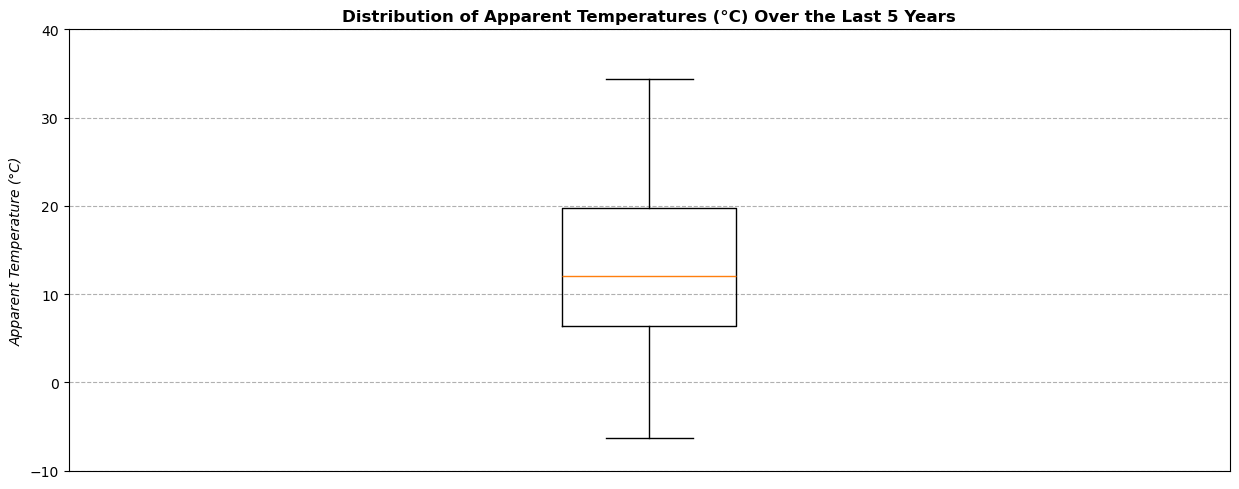

In [70]:
# Visualize a boxplot
visualize_boxplot(weather_df, "apparent_temperature_mean", "Apparent Temperature (°C)", "Distribution of Apparent Temperatures (°C) Over the Last 5 Years")

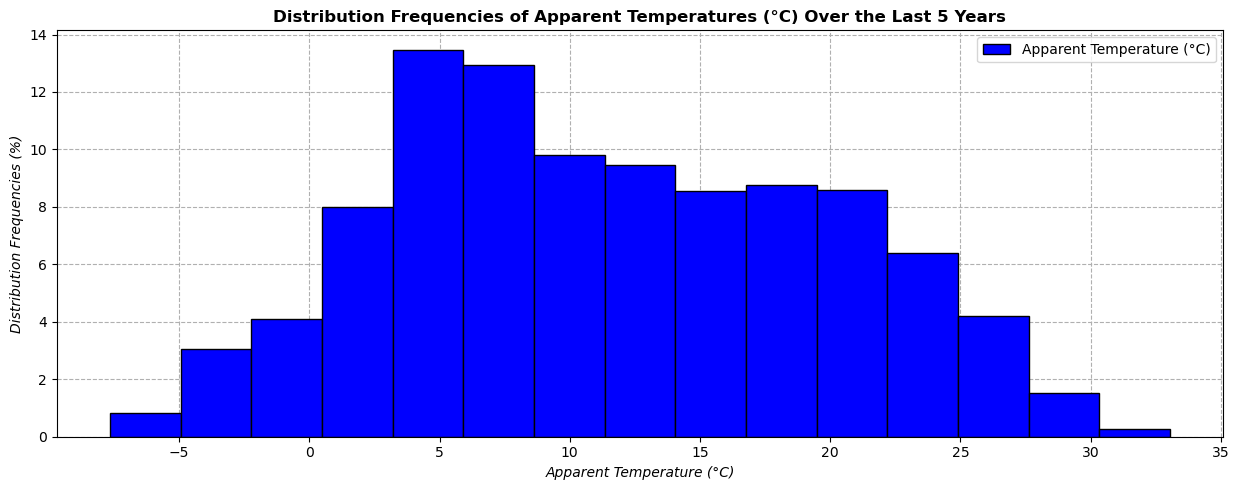

In [71]:
# Visualize a histogram
visualize_histogram(weather_df, "apparent_temperature_mean", 15, "Apparent Temperature (°C)", "Apparent Temperature (°C)", "Distribution Frequencies of Apparent Temperatures (°C) Over the Last 5 Years")

<h4 style = "text-align: center;">Comment(s)</h4>

<ul>
    <li>Descriptive Statistics
        <ul>
            <li>Range (40.7): Wide variability of apparent temperatures</li>
            <li>Minimum value (-6.3): Lowest apparent temperature is cold and negative (-6.3°C)</li>
            <li>Q1 (6.4): 25% of the apparent temperatures are colder than 6.4°C</li>
            <li>Median (12.0): 50% of the apparent temperatures are colder than 12.0°C</li> 
            <li>Q3 (19.8): 75% of the apparent temperatures are colder than 19.8°C</li>
            <li>Maximum value (34.4): Highest apparent temperature is hot (34.4°C)</li>
            <li>IQR (13.4): Middle 50% of the apparent temperatures are between 6.4°C and 19.8°C, which indicates a great variability in the central range</li> 
            <li>Mean (12.88): Mean apparent temperature is 12.88°C and higher than the median (12.88 > 12.0), which indicates a small right skew (influence of hotter temperatures)</li> 
            <li>Standard deviation (8.3): Dispersion from the mean of 8.3°C, which indicates a good spread around the mean</li>
        </ul>
    </li> 
    <br> 
    <li>Distribution Characteristics
        <ul> 
            <li>Mode (5.9): Most apparent temperatures are 5.9°C</li>
            <li>Skewness (0.17): Slight positive skew (influence of hotter temperatures)</li>
            <li>Lower bound (-13.7): Apparent temperatures colder than -13.7°C would be flagged as outliers</li> 
            <li>Upper bound (39.9): Apparent temperatures hotter than 39.9°C would be flagged as outliers</li>
            <li>Outlier (No outliers) and Outliers count (0): Uniform distribution</li>
            <li>Unique values count (346): 346 apparent temperatures are unique, which indicates a good diversity and reliable statistical analysis.</li> 
        </ul>
    </li> 
</ul>

<h3 style = "text-align: center;">Pattern(s)</h3>

<h4 style = "text-align: center;">Calculation(s)</h4>

In [76]:
# Filter and Store weather data by year in dataframes
year_2019_weather_df = weather_df[weather_df["year"] == 2019]
year_2020_weather_df = weather_df[weather_df["year"] == 2020]
year_2021_weather_df = weather_df[weather_df["year"] == 2021]
year_2022_weather_df = weather_df[weather_df["year"] == 2022]
year_2023_weather_df = weather_df[weather_df["year"] == 2023]
year_2024_weather_df = weather_df[weather_df["year"] == 2024]

years_of_weather_df = ["2024 (partial year)", "2023", "2022", "2021", "2020", "2019 (partial year)"]
weather_by_year_dfs_list = [
    year_2024_weather_df,
    year_2023_weather_df,
    year_2022_weather_df,     
    year_2021_weather_df,
    year_2020_weather_df, 
    year_2019_weather_df
]

<h4 style = "text-align: center;">Plot(s) and Visualization(s)</h4>

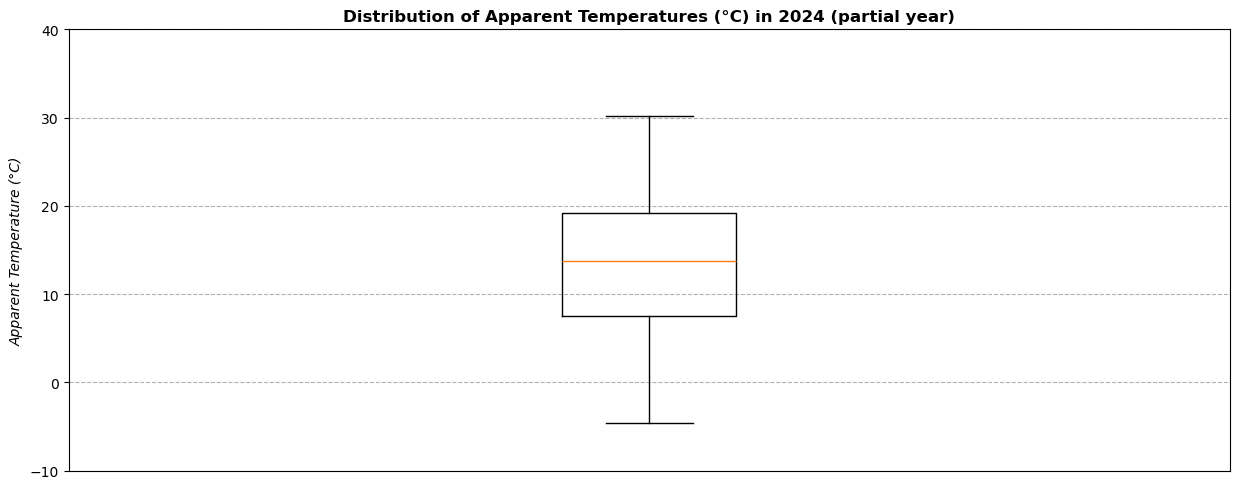

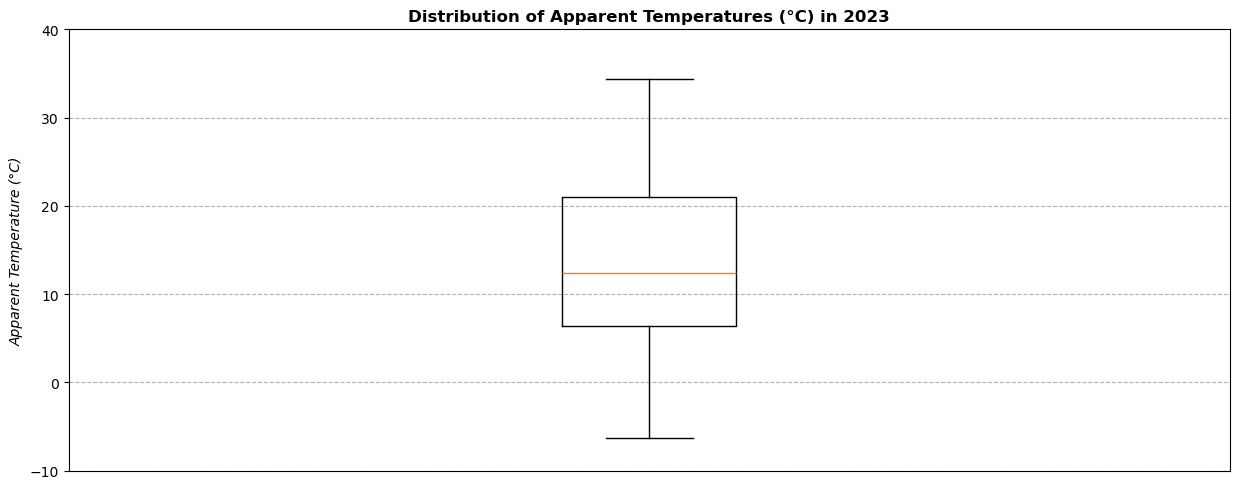

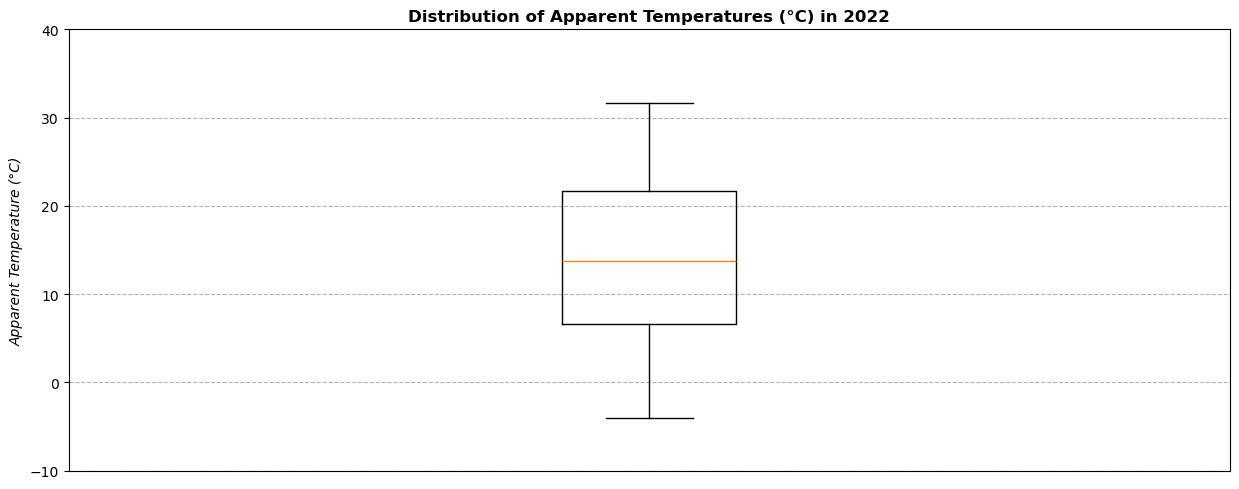

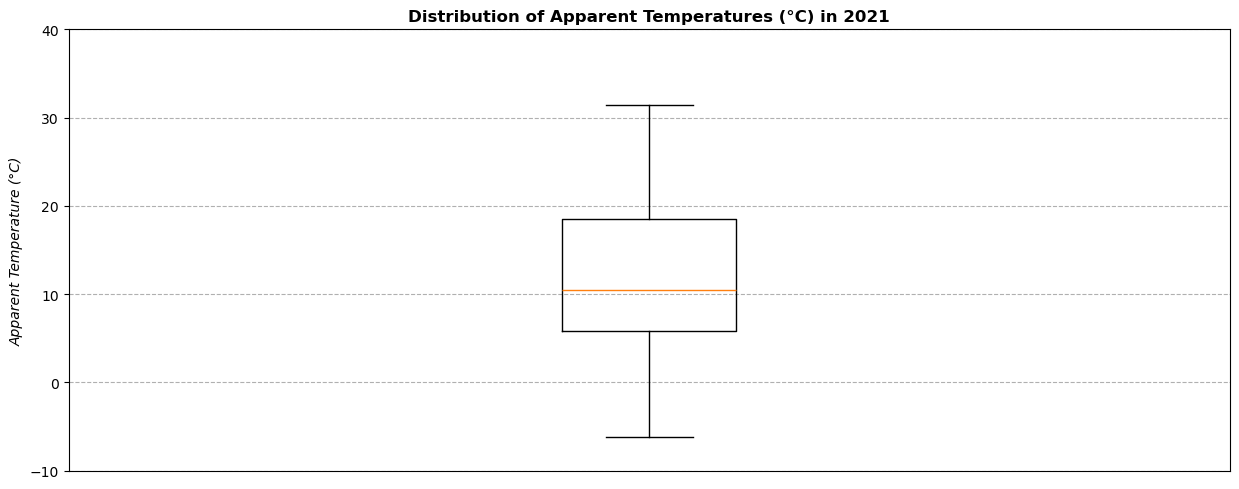

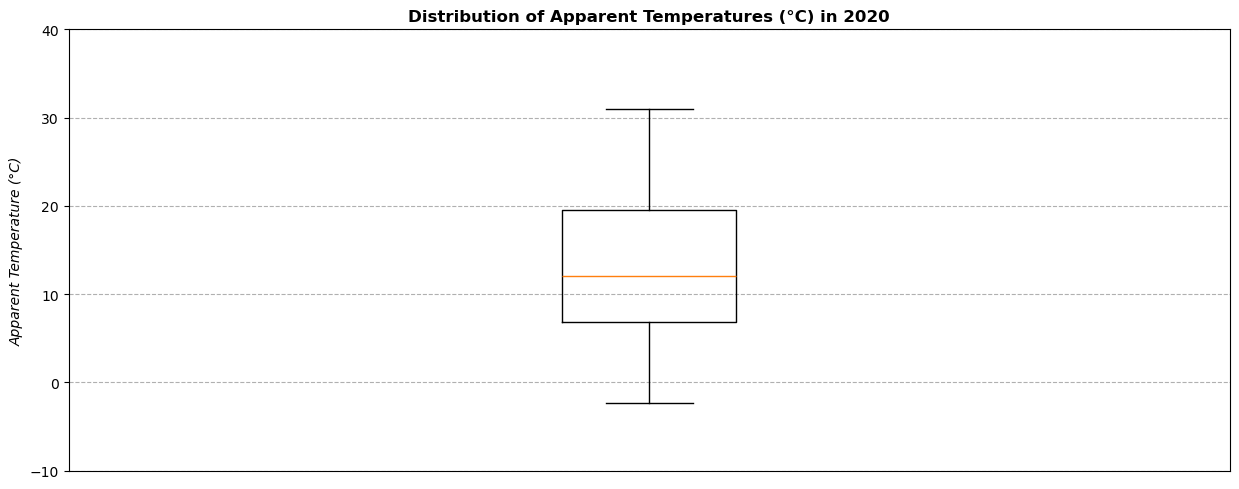

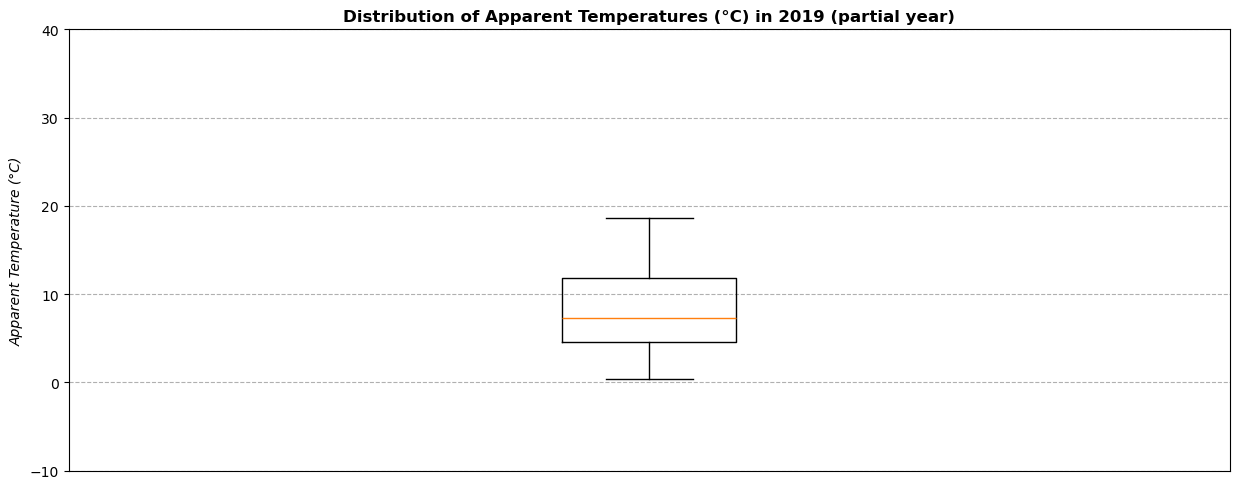

In [78]:
# Loop through each year and dataframe to visualize the distributions of apparent temperatures
for year_of_weather_df, weather_by_year_df in zip(years_of_weather_df, weather_by_year_dfs_list):
    visualize_boxplot(weather_by_year_df, "apparent_temperature_mean", "Apparent Temperature (°C)", f"Distribution of Apparent Temperatures (°C) in {year_of_weather_df}")
    print()

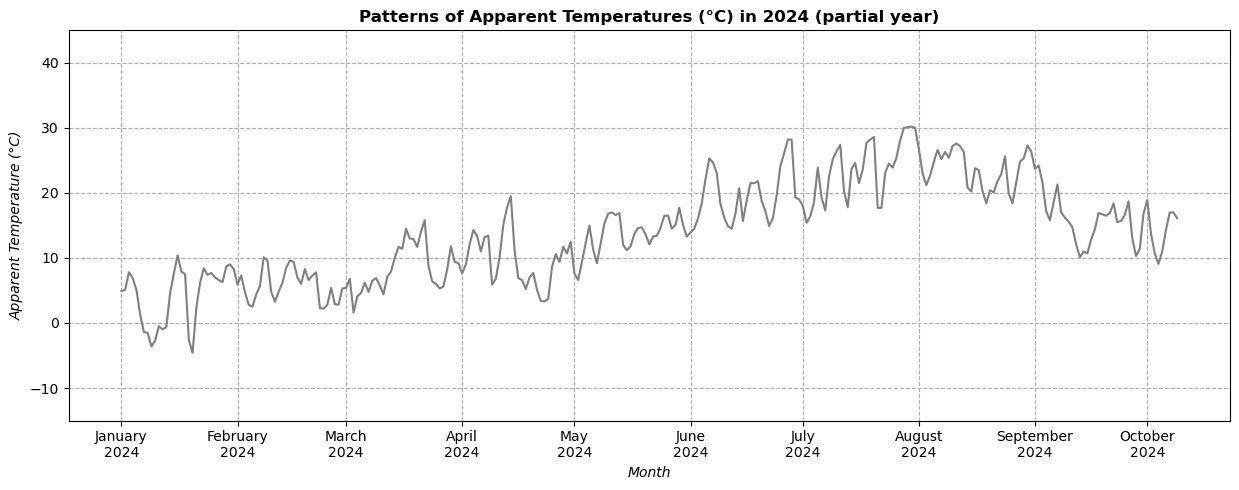

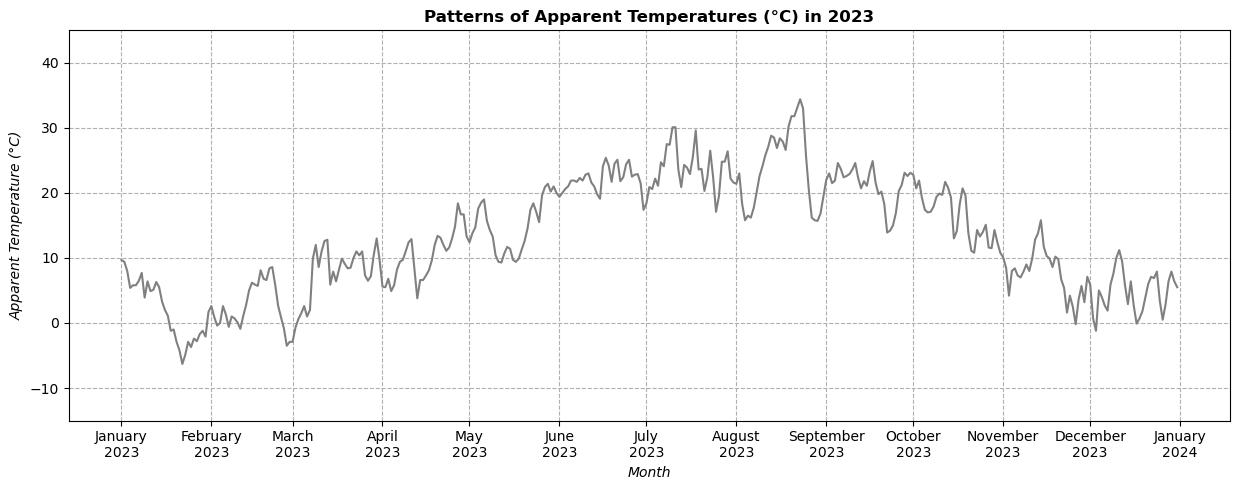

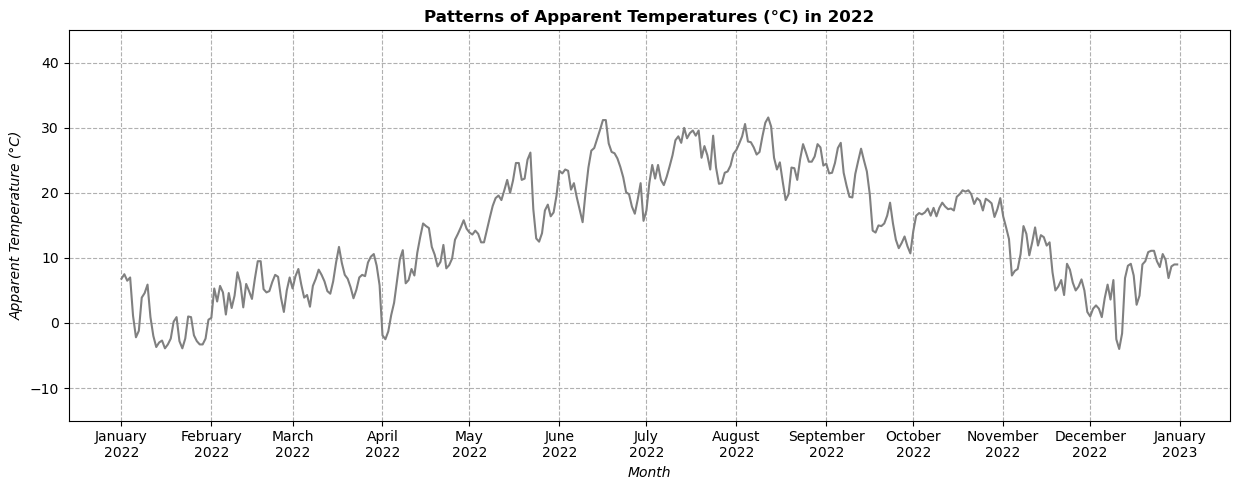

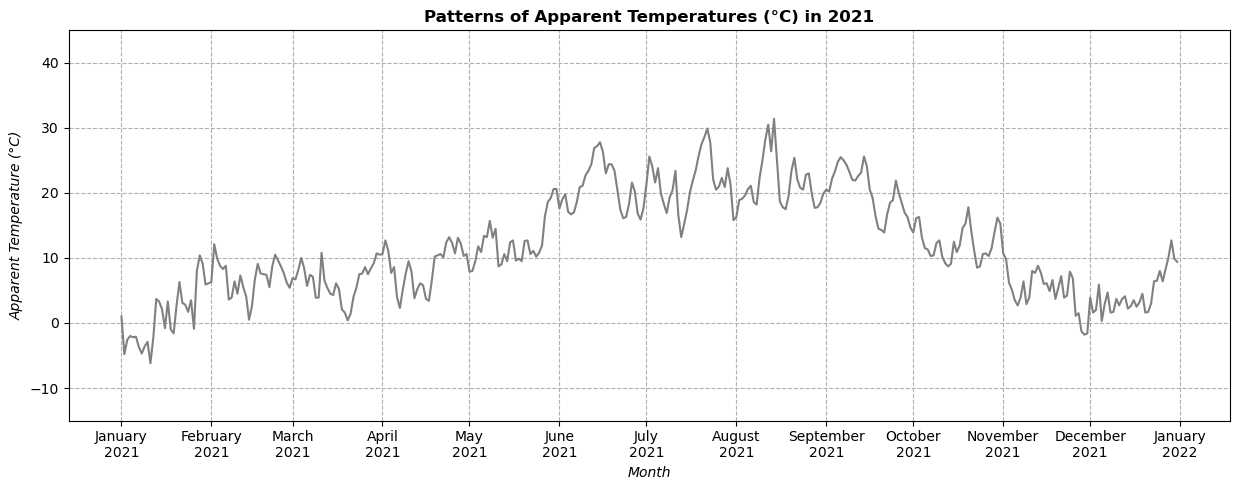

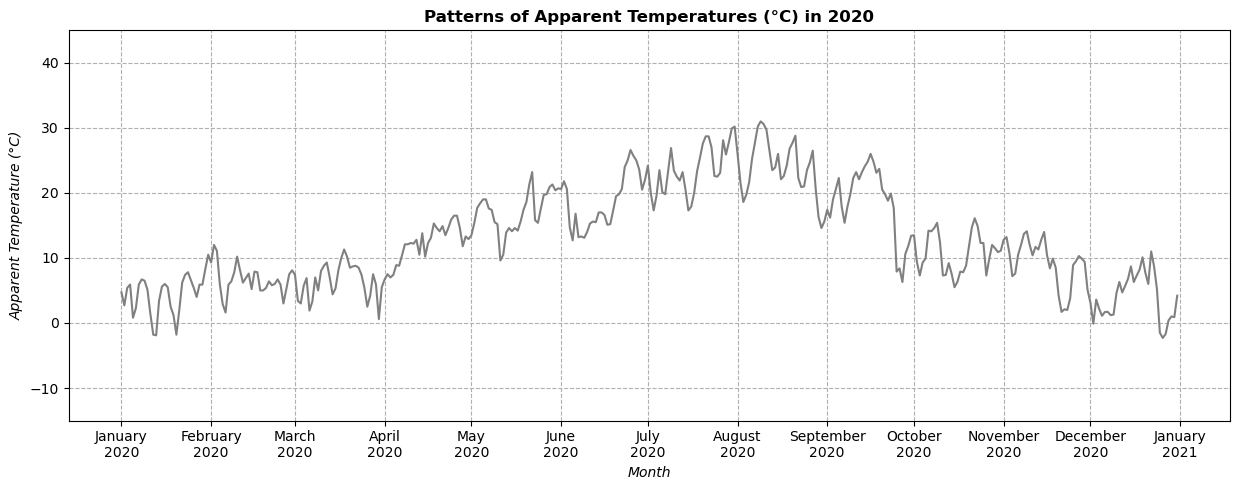

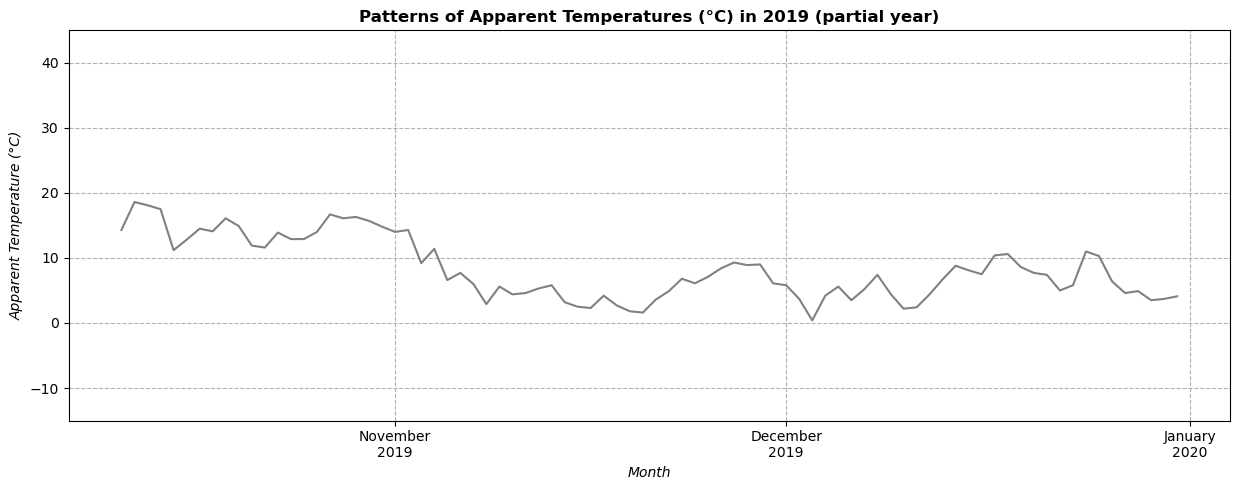

In [79]:
# Loop through each year and dataframe to visualize the patterns of apparent temperatures
for year_of_weather_df, weather_by_year_df in zip(years_of_weather_df, weather_by_year_dfs_list):
    visualize_lineplot(weather_by_year_df, "date","apparent_temperature_mean", "Month", "Apparent Temperature (°C)", f"Patterns of Apparent Temperatures (°C) in {year_of_weather_df}")
    print()   

<h4 style = "text-align: center;">Comment(s)</h4>

<p>Apart from 2019 and 2024 (partial years), there is a pattern of apparent temperatures</p>
<ul>
    <li>Stability from January to the end of March</li>
    <li>Increase from April to the end of June</li>
    <li>Stability from July to the end of September</li>
    <li>Decrease from October to the end of December</li>
</ul>
<p>This pattern corresponds to the 4 seasons</p>

<h3 style = "text-align: center;">Correlation(s)</h3>

<h4 style = "text-align: center;">Calculation(s)</h4>

In [84]:
# Check the correlations
check_correlations(weather_df)

CORRELATIONS OF NUMERIC COLUMNS
Column "apparent_temperature_max"
Very strong positive correlation (0.99) with "temperature_2m_max"
Very strong positive correlation (0.98) with "apparent_temperature_mean"
Very strong positive correlation (0.97) with "temperature_2m_mean"
Very strong positive correlation (0.95) with "soil_temperature_0_to_7cm"
Very strong positive correlation (0.93) with "soil_temperature_7_to_28cm"
Very strong positive correlation (0.91) with "apparent_temperature_min"
Very strong positive correlation (0.88) with "temperature_2m_min"
Very strong positive correlation (0.86) with "et0_fao_evapotranspiration"
Very strong positive correlation (0.86) with "dew_point_2m"
Very strong positive correlation (0.83) with "vapour_pressure_deficit"
Very strong positive correlation (0.82) with "soil_temperature_28_to_100cm"
Very strong positive correlation (0.76) with "shortwave_radiation_sum"
Very strong positive correlation (0.76) with "global_tilted_irradiance"
Strong positive cor

<h4 style = "text-align: center;">Plot(s) and Visualization(s)</h4>

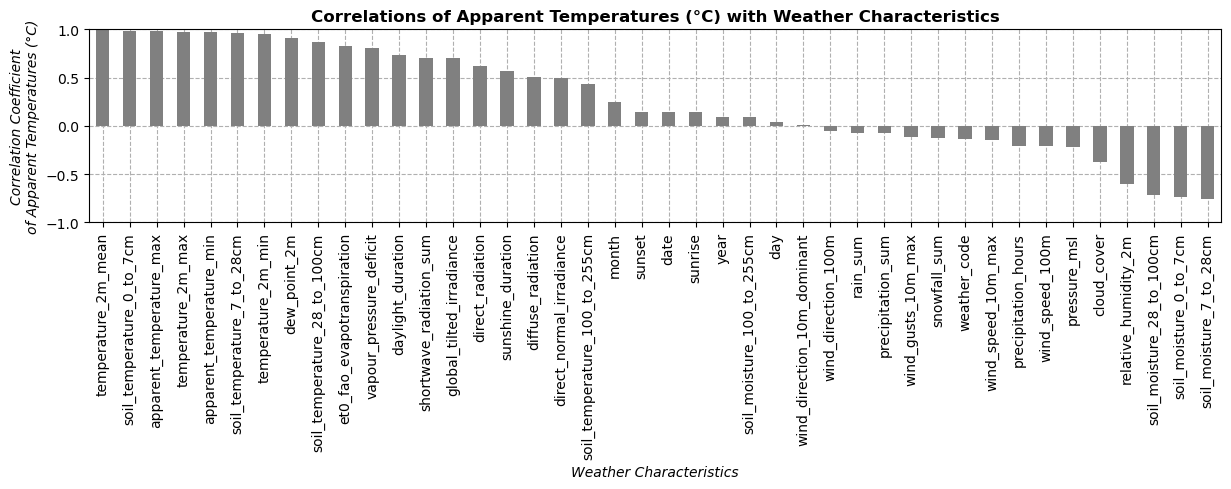

In [86]:
# Visualize a barplot (too many correlations to display a correlation heatmap)
weather_correlation_matrix = weather_df.corr()
apparent_temperature_mean_correlations = weather_correlation_matrix["apparent_temperature_mean"]

plt.figure(figsize = (12.5, 5))
ax = plt.gca()
ax.set_axisbelow(True)
apparent_temperature_mean_correlations.drop("apparent_temperature_mean").sort_values(ascending = False).plot(kind = "bar", color = "grey")
plt.grid(True, linestyle = "--")
plt.ylim(-1, 1)
plt.ylabel("Correlation Coefficient\nof Apparent Temperatures (°C)", fontstyle = "italic")
plt.xlabel("Weather Characteristics", fontstyle = "italic")
plt.title("Correlations of Apparent Temperatures (°C) with Weather Characteristics", fontweight = "bold")
plt.tight_layout()
plt.show()

<h4 style = "text-align: center;">Comment(s)</h4>

<ul>
    <li>Very strong positive correlations
        <ul>
            <li>Columns "temperature_2m_mean", "apparent_temperature_max", "temperature_2m_max", "apparent_temperature_min", "temperature_2m_min" (0.99; 0.98; 0.97; 0.97; 0.95): Apparent temperature mean increases with temperatures</li>
            <li>Columns "soil_temperature_0_to_7cm", "soil_temperature_7_to_28cm", "soil_temperature_28_to_100cm"(0.98; 0.96; 0.87): Apparent temperature mean increases with soil temperatures</li>
            <li>Column "dew_point_2m" (0.91): Apparent temperature mean increases with dew point</li>
            <li>Column "et0_fao_evapotranspiration" (0.82): Apparent temperature mean increases with evapotranspiration</li>
            <li>Column "vapour_pressure_deficit" (0.81): Apparent temperature mean increases with vapour pressure deficit</li>
        </ul>
    </li>
    <br>
    <li>Very strong negative correlations
        <ul>
            <li>Column "soil_moisture_7_to_28cm" (-0.76): Apparent temperature mean decreases with soil moisture</li>
        </ul>
    </li>
    <br>
    <li>Strong positive correlations
        <ul>
            <li>Column "daylight_duration" (0.73): Apparent temperature mean increases with daylight hours</li>
            <li>Column "shortwave_radiation_sum" (0.70): Apparent temperature mean increases with shortwave radiations</li>
            <li>Column "global_tilted_irradiance" (0.70): Apparent temperature mean increases with global tilted irradiance</li>
            <li>Column "direct_radiation" (0.62): Apparent temperature mean increases with direct radiation</li>
            <li>Column "sunshine_duration" (0.56): Apparent temperature mean increases with duration of sunshine</li>
            <li>Column "diffuse_radiation" (0.50): Apparent temperature mean increases with diffuse radiations</li>
        </ul>
    </li>
    <br>
    <li>Strong negative correlations
        <ul>
            <li>Column "relative_humidity_2m" (-0.61): Apparent temperature mean decreases with relative humidity</li>
            <li>Columns "soil_moisture_28_to_100cm", "soil_moisture_0_to_7cm" (-0.72; -0.75): Apparent temperature mean decreases with soil moisture</li>
        </ul>
    </li>
</ul>

---
<h2 style = "text-align: center;"><em>Model Data</em></h2>

<h3 style = "text-align: center;">Backup</h3>

In [91]:
# Save the dataframe
weather_model_df = weather_df.copy()

<h3 style = "text-align: center;">Preparation</h3>

In [93]:
# Add columns for seasons
season_mapping = {
    12: "winter", 1: "winter", 2: "winter",
    3: "spring", 4: "spring", 5: "spring",
    6: "summer", 7: "summer", 8: "summer",
    9: "fall", 10: "fall", 11: "fall"
}
weather_model_df["season"] = weather_model_df["month"].map(season_mapping)
weather_model_df = pd.get_dummies(weather_model_df, columns = ["season"], drop_first = False)
check_dataframe(weather_model_df)

GENERAL INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 47 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   weather_code                   1826 non-null   float64       
 1   temperature_2m_max             1826 non-null   float64       
 2   temperature_2m_min             1826 non-null   float64       
 3   temperature_2m_mean            1826 non-null   float64       
 4   apparent_temperature_max       1826 non-null   float64       
 5   apparent_temperature_min       1826 non-null   float64       
 6   apparent_temperature_mean      1826 non-null   float64       
 7   sunrise                        1826 non-null   datetime64[ns]
 8   sunset                         1826 non-null   datetime64[ns]
 9   daylight_duration              1826 non-null   float64       
 10  sunshine_duration              1826 non-null   float64       
 1

<h3 style = "text-align: center;">Training</h3>

In [95]:
# Define the correlated values
X = weather_model_df[[
    "temperature_2m_max",
    "temperature_2m_mean",
    "temperature_2m_min",
    "shortwave_radiation_sum",
    "global_tilted_irradiance",
    "soil_temperature_0_to_7cm",
    "soil_temperature_7_to_28cm",
    "soil_temperature_28_to_100cm",
    "dew_point_2m",
    "vapour_pressure_deficit",
    "et0_fao_evapotranspiration",
    "soil_moisture_0_to_7cm",
    "soil_moisture_7_to_28cm",
    "soil_moisture_28_to_100cm",
    "daylight_duration",
    "sunshine_duration",
    "direct_radiation",
    "direct_normal_irradiance",
    "cloud_cover",
    "relative_humidity_2m",
    "season_fall",
    "season_spring",
    "season_summer",
    "season_winter"
]]

# Define the values to predict
y = weather_model_df["apparent_temperature_mean"]

# Create polynomial features
polynomial_degree = 2
polynomial_features = PolynomialFeatures(degree = polynomial_degree)

# Standardize and transform features with polynomial features
pipeline = make_pipeline(
    StandardScaler(),
    polynomial_features,
    LinearRegression()
)

# Train the model (with "Train, Test, Split")
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state = 42)

weather_model = pipeline.fit(X_train, y_train)

# Make predictions
y_train_predictions = weather_model.predict(X_train)
y_test_predictions = weather_model.predict(X_test)

<h3 style = "text-align: center;">Evaluation</h3>

In [97]:
# Evaluate the model with metrics
# Calculate the R² scores
r2_train_apparent_temperature_mean = r2_score(y_train, y_train_predictions)
r2_test_apparent_temperature_mean = r2_score(y_test, y_test_predictions)
# Calculate the Mean Squared Error (MSE)
mse_train_apparent_temperature_mean = mean_squared_error(y_train, y_train_predictions)
mse_test_apparent_temperature_mean = mean_squared_error(y_test, y_test_predictions)
# Calculate the Mean Absolute Error (MAE)
mae_train_apparent_temperature_mean = mean_absolute_error(y_train, y_train_predictions)
mae_test_apparent_temperature_mean = mean_absolute_error(y_test, y_test_predictions)

# Perform a Cross-Validation on the model
cv_scores = cross_val_score(weather_model, X, y, cv = 5, scoring = "r2")

# Store a sample of apparent temperatures and their predictions in a dataframe
sample_of_apparent_temperatures_predictions = y_test_predictions[-5:]
sample_of_apparent_temperatures = y_test[-5:]
sample_of_apparent_temperatures_predictions_df = pd.DataFrame(
    {
        "apparent_temperature_mean": sample_of_apparent_temperatures.values,
        "predicted_apparent_temperature_mean": sample_of_apparent_temperatures_predictions.round(2),
    }
)

# Print the results of the evaluation
print("METRICS ON THE OVERALL MODEL")
print(f"Cross-Validation R² scores: {cv_scores}")
print(f"Mean Cross-Validation R² score: {cv_scores.mean():.4f}")
print(f"Standard-Deviation Cross-Validation R² score: {cv_scores.std():.4f}")
print()
print("METRICS ON THE MEAN APPARENT TEMPERATURES")
print(f"R² Score for the training dataset: {r2_train_apparent_temperature_mean:.4f}")
print(f"R² Score for the test dataset: {r2_test_apparent_temperature_mean:.4f}")
print(f"MSE for the training dataset: {mse_train_apparent_temperature_mean:.2f}")
print(f"MSE for the test dataset: {mse_test_apparent_temperature_mean:.2f}")
print(f"MAE for the training dataset: {mae_train_apparent_temperature_mean:.2f}")
print(f"MAE for the test dataset: {mae_test_apparent_temperature_mean:.2f}")
print()
print("SAMPLE OF APPARENT TEMPERATURES AND PREDICTIONS")
print(sample_of_apparent_temperatures_predictions_df)
print()

METRICS ON THE OVERALL MODEL
Cross-Validation R² scores: [0.99777357 0.99829221 0.99829968 0.99814828 0.99711325]
Mean Cross-Validation R² score: 0.9979
Standard-Deviation Cross-Validation R² score: 0.0004

METRICS ON THE MEAN APPARENT TEMPERATURES
R² Score for the training dataset: 0.9990
R² Score for the test dataset: 0.9980
MSE for the training dataset: 0.07
MSE for the test dataset: 0.13
MAE for the training dataset: 0.20
MAE for the test dataset: 0.28

SAMPLE OF APPARENT TEMPERATURES AND PREDICTIONS
   apparent_temperature_mean  predicted_apparent_temperature_mean
0                       15.0                                15.29
1                        8.6                                 8.24
2                       21.9                                22.24
3                        5.5                                 5.54
4                       20.5                                20.74



<h3 style = "text-align: center;">Comment(s)</h3>

<p>The model performs consistently well across different subsets (high Cross-validation R² scores, with Mean close to 1 and Standard deviation close to 0)</p>

<p>It explains nearly all the variance in the target variable for both the training and test datasets (R² scores are very close to 1), with little overfitting (R² score on the test dataset is inferior to R² score on the training dataset)</p>

<p>Its predictions are close to the actual values (low MSE and MAE) and it generalizes well to unseen data (small difference between the training dataset and the test dataset)</p>

---
<h2 style = "text-align: center;"><em>Communicate the Results of the Analysis</em></h2>

<p style = "text-align: center;">I created a model able to predict apparent temperatures, for a given day, at a given address in France, to assess the weather conditions</p>